In [1]:
from imports import *

**load data**

In [2]:
# Leer el archivo Parquet
table_loaded = pq.read_table("6'_5ophits.parquet")

# Convertir de vuelta a Awkward Array o NumPy
input = ak.to_numpy(table_loaded["input"])
nuvT_c = ak.to_numpy(table_loaded["nuvT_c"])

print("Loaded matrix shape:", input.shape)  # Debería ser (21900, 400, 4)
print("Loaded vector shape:",nuvT_c.shape)  # Debería ser (21900,))
print("Matrix sample:\n", input[0, :3])
print("Vector sample:", nuvT_c[:3])

Loaded matrix shape: (21964, 20, 4)
Loaded vector shape: (21964,)
Matrix sample:
 [[1478.72460015   70.            0.            0.        ]
 [1480.72460015   16.            0.            0.        ]
 [1480.72460015   14.            0.            0.        ]]
Vector sample: [1462.42688725 1480.24647869  643.02543649]


In [3]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(input, nuvT_c, test_size=0.2, random_state=42)

# Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, ELU
from tensorflow.keras.regularizers import l2

class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Mask is True where we want to KEEP the data (not -1000 in all features)
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

# Define the model with functional API
inputs = Input(shape=(20,4))
masked_inputs, mask = MaskNegative1000()(inputs)

lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
lstm_out2 = LSTM(128, return_sequences=False)(lstm_out1)

x = Dense(64, kernel_regularizer=l2(0.01))(lstm_out2)
x = LeakyReLU(alpha=0.1)(x)  # Aplicando LeakyReLU
x = Dropout(0.3)(x)
outputs = Dense(1)(x)

model11 = Model(inputs, outputs)
model11.compile(optimizer='adam', loss='mse', metrics=['mae'])
model11.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 20, 4)]      0           []                               
                                                                                                  
 mask_negative1000_10 (MaskNega  ((None, 20, 4),     0           ['input_11[0][0]']               
 tive1000)                       (None, 20))                                                      
                                                                                                  
 lstm_20 (LSTM)                 (None, 20, 256)      267264      ['mask_negative1000_10[0][0]',   
                                                                  'mask_negative1000_10[0][1]']   
                                                                                            

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definir los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Se basa en la pérdida de validación
    patience=5,  # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True,  # Recupera los mejores pesos
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Guardará el mejor modelo en este archivo
    monitor='val_loss',
    save_best_only=True,  # Guarda solo si la pérdida de validación mejora
    verbose=0
)

# Train the model
history = model11.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,  # Adjust as needed
    batch_size=32,  # Adjust based on your memory
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]  # Agregar callbacks aquí
)

Epoch 1/30
550/550 [==============================] - 16s 14ms/step - loss: 186978.9219 - mae: 268.2959 - val_loss: 6019.3838 - val_mae: 44.9615
Epoch 2/30
550/550 [==============================] - 5s 9ms/step - loss: 14886.2285 - mae: 81.0751 - val_loss: 7584.2515 - val_mae: 63.8979
Epoch 3/30
550/550 [==============================] - 5s 9ms/step - loss: 13791.5615 - mae: 78.8558 - val_loss: 9533.0029 - val_mae: 76.3428
Epoch 4/30
550/550 [==============================] - 5s 9ms/step - loss: 12544.6865 - mae: 74.2820 - val_loss: 5839.1870 - val_mae: 51.9614
Epoch 5/30
550/550 [==============================] - 5s 9ms/step - loss: 11553.9121 - mae: 70.6579 - val_loss: 5895.2637 - val_mae: 42.6334
Epoch 6/30
550/550 [==============================] - 5s 9ms/step - loss: 11071.4014 - mae: 68.6315 - val_loss: 2952.3223 - val_mae: 25.6659
Epoch 7/30
550/550 [==============================] - 5s 9ms/step - loss: 10424.2275 - mae: 66.1759 - val_loss: 5898.9199 - val_mae: 48.6776
Epoch 8/3

In [30]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5', custom_objects={'MaskNegative1000': MaskNegative1000})

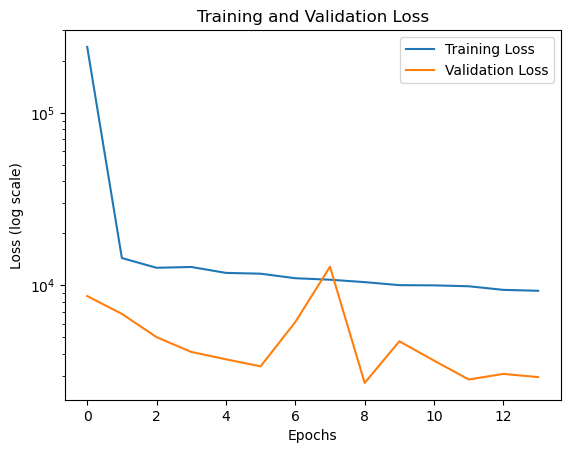

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Escala logarítmica en el eje Y
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [31]:
# Evaluate on test set
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Make predictions
predictions = best_model.predict(X_test)
print("Sample predictions:", predictions[:5].flatten())
print("Sample true values:", y_test[:5])

Test Loss (MSE): 2317.7825, Test MAE: 22.9349
Sample predictions: [1383.7876   258.66965 1218.9808   590.3465  1282.3724 ]
Sample true values: [1368.17139222  246.55045488 1215.64841391  588.31544388 1253.36117219]


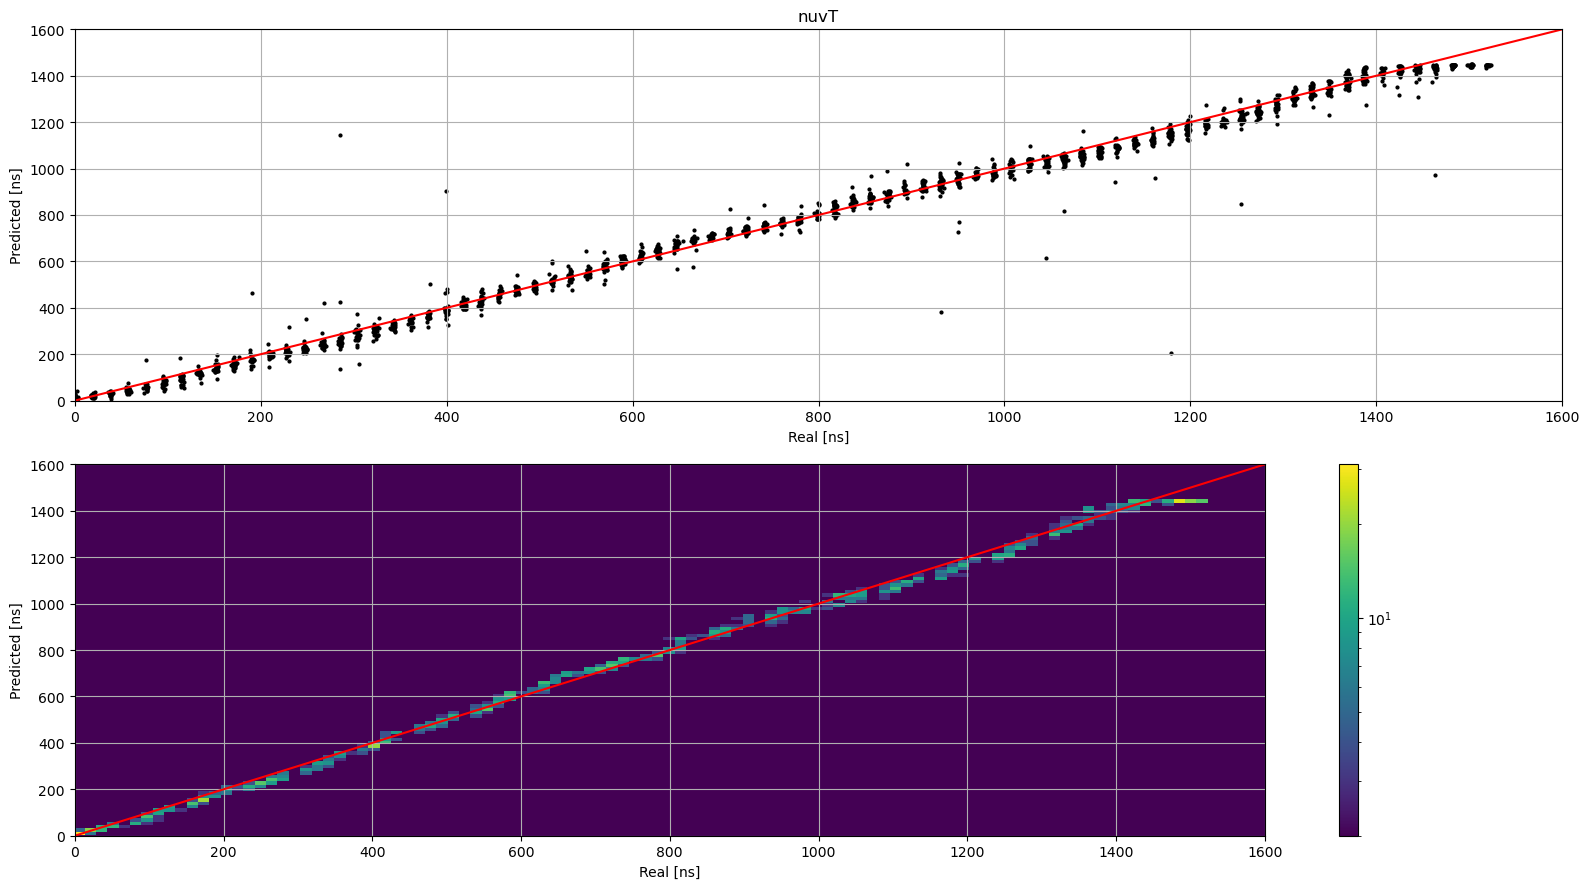

In [17]:
import matplotlib.colors as mcolors
fig, axs = plt.subplots(2,1,figsize=(16,9))

axs[0].scatter(y_test, predictions, color="black",s=4)
axs[0].grid()

axs[0].plot([0,1600],[0,1600],color="r")
axs[0].title.set_text('nuvT')
axs[0].set_xlim([0,1600])
axs[0].set_ylim([0,1600])
axs[0].set_ylabel('Predicted [ns]')
axs[0].set_xlabel('Real [ns]')

im0 = axs[1].hist2d(y_test, predictions.flatten(), bins=(100, 100), cmap='viridis', cmin=2, norm=mcolors.LogNorm())
fig.colorbar(im0[3], ax=axs[1])
axs[1].grid()

axs[1].plot([0,1600],[0,1600],'r')
axs[1].set_xlim([0,1600])
axs[1].set_ylim([0,1600])
axs[1].set_ylabel('Predicted [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')



fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

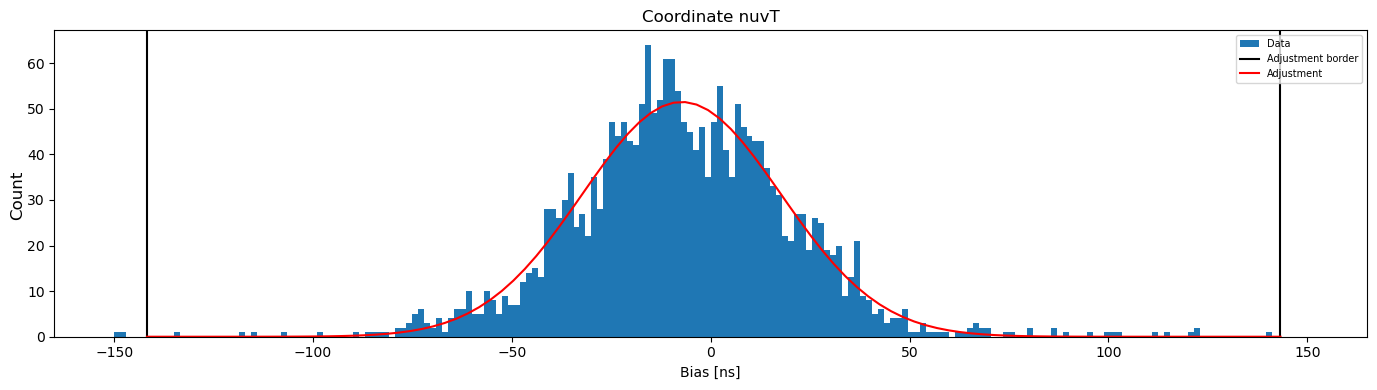

Bias Adjustment variables
------------------
Mean nuvT = -7.32
Sigma nuvT = 25.00
------------------


In [18]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value
diffnuvT = ak.flatten(predictions) - y_test

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, ax, coord_name, ini, fin, hist_range):
    counts, bins, patches = ax.hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    ax.axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    ax.axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0, bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf]))
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    ax.plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    ax.set_xlabel('Bias [ns]')  # Set different xlabel for nuvT
    ax.set_title(f'Coordinate {coord_name}')
    ax.legend(prop={"size": 7})

    return popt

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(14, 4))

# Call the function with updated range for nuvT
popt_nuvT = fit_and_plot_hist(diffnuvT, ax, 'nuvT', 5, 195, hist_range=[-150, 150])

# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean nuvT = {popt_nuvT[1]:.2f}')
print(f'Sigma nuvT = {popt_nuvT[2]:.2f}')
print('------------------')
